In [1]:
import math
import requests

import numpy as np
import sklearn.datasets as ds
import torch
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import nn
from torch.optim import SGD, Adam
import torch.nn.functional as F

%matplotlib inline

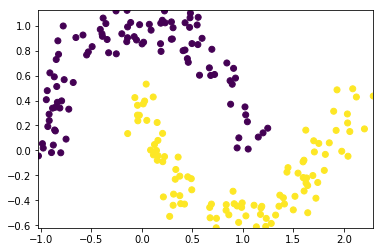

In [2]:
def load_data():
    torch.manual_seed(0)
    
    data = requests.get('https://pastebin.com/raw/qkEDjYJE').text
    data = [[float(x) for x in line.split('\t')] for line in data.split('\n')]

    data = np.array(data)
    X = torch.tensor(data[:, :2], dtype=torch.float)
    y = torch.tensor(data[:, 2], dtype=torch.float).view((-1, 1))

    l = X.size(0)
    l_train, l_test = int(l * 0.7), int(l * 0.2)

    data = TensorDataset(X, y)
    train_ds, test_ds, val_ds = random_split(data, [l_train, l_test, l - l_train - l_test])
    
    return train_ds, test_ds, val_ds


def vis_data(ax, ds):
    X = np.array([x.numpy() for x, _ in ds])
    y = np.array([y.numpy() for _, y in ds])
    
    x_lim = np.min(X[:, 0]), np.max(X[:, 0])
    y_lim = np.min(X[:, 1]), np.max(X[:, 1])
   
    ax.scatter(X[:, 0], X[:, 1], c=y.ravel())

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
vis_data(plt.gca(), load_data()[1])

In [3]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)    
        
    def forward(self, x):
        x1 = self.linear(x)
        return torch.sigmoid(self.linear(x2))

    
class SimpleClassifierPoly(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(6, 1)
        
    def forward(self, x):
        t = torch.cat([x, x**2, x**3], 1)            
        return torch.sigmoid(self.linear(t))
    
    
class SimpleClassifierRBF(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 10)    
        self.linear2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x1 = self.linear(x)
        x2 = torch.exp(-x1**2 / 4)
        return torch.sigmoid(self.linear2(x2))    

In [4]:
def test_model(model, ds):
    with torch.no_grad():
        currect = 0
        total = 0
        for X_val, y_val in ds:
            y_pred = (model(X_val) >= 0.5)
            y_val = (y_val >= 0.5)

            currect += y_pred.eq(y_val).sum().item()
            total += X_val.size(0)
       
        return currect / total
    

def train_model(train, val, test, model, max_epochs=300):
    optimizer = Adam(model.parameters(), lr=1e-2)

    loss = nn.BCELoss()
    train_loader = DataLoader(dataset=train_ds, batch_size=30)
    val_loader = DataLoader(dataset=val_ds)
    test_loader = DataLoader(dataset=test_ds)

    for epoch in range(max_epochs):
        for X_batch, y_batch in train_loader:   
            model.train()
            y_pred = model(X_batch)    
            bce = loss(y_pred, y_batch)

            bce.backward()        

            optimizer.step()
            optimizer.zero_grad()       
           
        if epoch % 50 == 0:
            model.eval()
            acc = test_model(model, val_loader)
            print(f'Epoch = {epoch}, acc = {acc:.5f}, loss = {bce}')    
            
    print(f'Test results acc = {test_model(model, test_loader):.5f}')      

In [5]:
train_ds, test_ds, val_ds = load_data()
model = SimpleClassifierPoly()
train_model(train_ds, test_ds, val_ds, model)

Epoch = 0, acc = 0.81188, loss = 0.4845123887062073
Epoch = 50, acc = 0.96040, loss = 0.06256405264139175
Epoch = 100, acc = 0.98020, loss = 0.0277324877679348
Epoch = 150, acc = 0.99010, loss = 0.015158497728407383
Epoch = 200, acc = 1.00000, loss = 0.009255372919142246
Epoch = 250, acc = 1.00000, loss = 0.006116038653999567
Test results acc = 1.00000


In [6]:
def vis_model(ax, model, ds):
    X = np.array([x.numpy() for x, _ in ds])
    y = np.array([y.numpy() for _, y in ds])
    
    x_lim = np.min(X[:, 0]), np.max(X[:, 0])
    y_lim = np.min(X[:, 1]), np.max(X[:, 1])
    xx, yy = np.meshgrid(np.linspace(*x_lim, 150), 
                         np.linspace(*y_lim, 150))
    zz = model(torch.FloatTensor(np.array([(p1, p2) for (p1, p2) in zip(xx.ravel(), yy.ravel())])))
    ax.pcolormesh(xx, yy, zz.reshape(xx.shape) >= 0.5, cmap=plt.cm.get_cmap('Set2'))
    ax.scatter(X[:, 0], X[:, 1], c=y.ravel())

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

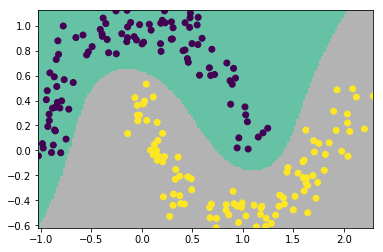

In [7]:
model.eval()
vis_model(plt.gca(), model, test_ds)